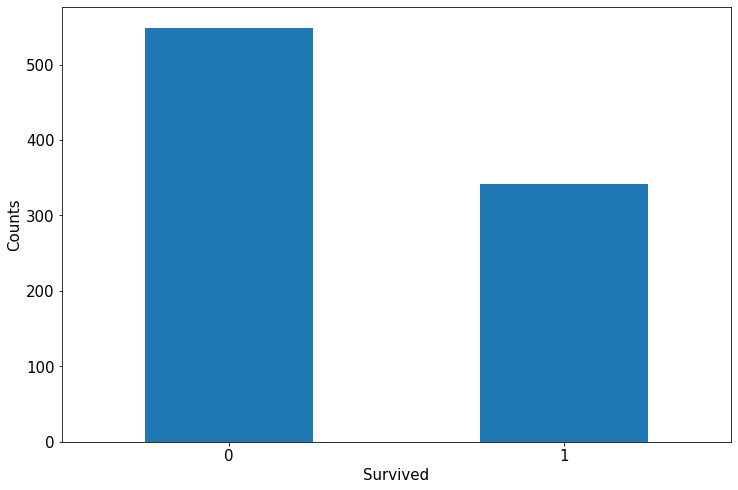

In [1]:
import os
import datetime
import numpy as np
import pandas as od
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 8 + "%s" % nowtime)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 一、准备数据 ！！！！
# titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存

# 结构化数据一般会使用Pandas中的DataFrame进行预处理
dftrain_raw = pd.read_csv("C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/titanic/train.csv")
dftest_raw = pd.read_csv("C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/titanic/test.csv")
dftrain_raw.head(10)
# 利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）

# 1. label的分布情况
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',figsize = (12,8),fontsize = 15, rot = 0)
ax.set_ylabel('Counts', fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

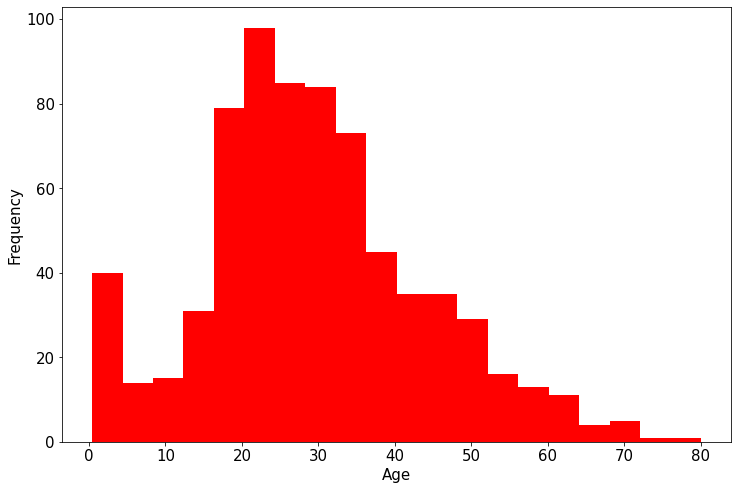

In [48]:
# 2. 年龄分布情况
# 这里y轴表示出现率

%matplotlib inline
# 用来生成图像
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist', bins = 20, color = 'red',figsize = (12,8), fontsize = 15 )
ax.set_ylabel('Frequency', fontsize = 15)
ax.set_xlabel('Age', fontsize = 15)
plt.show()

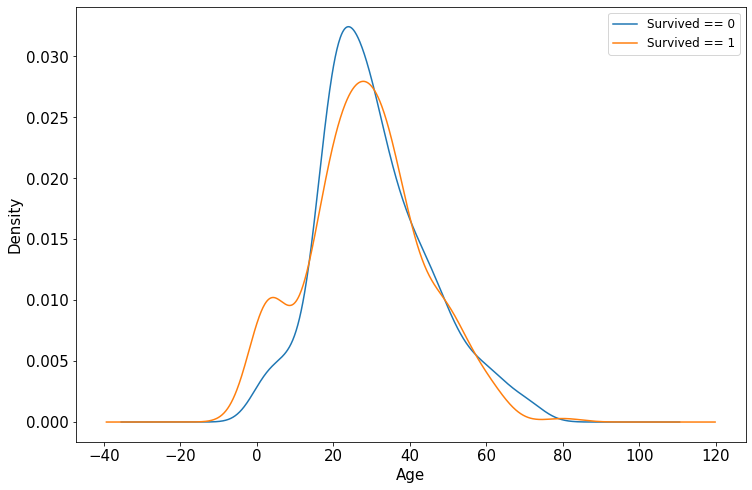

In [3]:
# 3. 年龄和label的相关性

# 也就是哪个年龄段更容易发生死亡
# 从这里可以看出老人和小孩的死亡率都比较低
# 因为当时救生艇主要是装载老人和小孩

%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density', figsize = (12,8), fontsize = 15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density', figsize = (12,8), fontsize = 15)
ax.legend(['Survived == 0','Survived == 1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [4]:
# 4. 正式开始据预处理
def preprocessing(dfdata):
    dfresult = pd.DataFrame()
#   DataFrame是由多种类型的列构成的二维标签数据结构.
#   往往包含index(行标签)和columns(列标签), 彼此独立, 互不影响
#   直观理解:DataFrame 是带标签的二维数组

#     Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)
    
#     Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)
                           
#     Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')
                           
#     SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
                           
#     Cabin
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')
                           
#     Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na = True)
    dfEmbarked.columns = ['Embarked_'+str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)
    
    return(dfresult)
    
x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[['Survived']].values
    
x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values
    
print("x_train.shape = " , x_train.shape)
print("x_test.shape = " , x_test.shape)
    
print("y_train.shape = " , y_train.shape)
print("y_test.shape = " , y_test.shape)

x_train.shape =  (891, 15)
x_test.shape =  (179, 15)
y_train.shape =  (891, 1)
y_test.shape =  (179, 1)


In [5]:
# 5. 进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道
dl_train = DataLoader(TensorDataset(
                         torch.tensor(x_train).float(), 
                         torch.tensor(y_train).float()),
                         shuffle = True,
                         batch_size = 8)


dl_valid = DataLoader(TensorDataset(
                         torch.tensor(x_test).float(), 
                         torch.tensor(y_test).float()),
                         shuffle = False,
                         batch_size = 8)

for features, labels in dl_train:
    print(features, labels)
    break

tensor([[ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  3.0000,
          1.0000, 25.4667,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 14.0000,  0.0000,  1.0000,
          0.0000, 11.2417,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  7.7500,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  6.8583,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000, 31.0000,  0.0000,  1.0000,
          0.0000, 52.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  8.0000,  0.0000,  3.0000,
          1.0000, 21.0750,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  5.0000,  0.0000,  1.0

In [6]:
# 二、定义模型！！！！！！！
# 使用Pytorch通常有三种方式构建模型：
# 使用nn.Sequential按层顺序构建模型，
# 继承nn.Module 基类构建自定义模型，
# 继承nn.Module基类构建模型并辅助应用模型容器进行封装。 
# 此处选择使用最简单的nn.Sequential，按层顺序模型


def create_net():
    net = nn.Sequential()
    net.add_module("linear1",nn.Linear(15,20))
    net.add_module("relu1",nn.ReLU())
    net.add_module("linear2",nn.Linear(20,15))
    net.add_module("relu2",nn.ReLU())    
    net.add_module("linear3",nn.Linear(15,1))
    net.add_module("sigmoid",nn.Sigmoid())
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [7]:
from torchkeras import summary 
summary(net,input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


In [35]:
# 三、训练模型！！！！！！
# Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。 
# 有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。
# 本次实验使用比较通用的脚本形式。

from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params = net.parameters(), lr = 0.01)
metric_func = lambda y_pred,y_true:accuracy_score(y_true.data.numpy(), y_pred.data.numpy()>0.5)
metric_name = "accuracy"

epochs = 20
log_step_freq = 30

dfhistory = pd.DataFrame(columns= ["epoch", "loss", metric_name, "val_loss", "val_" + metric_name])
print("Start training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(1,epochs+1):
#     1. 训练循环------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
#         梯度清零
        optimizer.zero_grad()
#         正向传播求损失
        predicitions = net(features)
        loss = loss_func(predicitions, labels)
        metric = metric_func(predicitions, labels)
        
#         反向传播求梯度
        loss.backward()
        optimizer.step()
        
#         打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0 :
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") % (step, loss_sum/step, metric_sum/step))
            
#     2. 验证循环------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_valid, 1):
        predicitions = net(features)
        val_loss = loss_func(predicitions, labels)
        val_metric = metric_func(predicitions, labels)
        
        val_loss_sum += val_loss.item()
        val_metric_sum =+ val_metric.item()
        
#     3. 记录日志------------------------------------------------
    info = (epoch, loss_sum / step, metric_sum / step, val_loss_sum / val_step, val_metric_sum / val_step)
    dfhistory.loc[epoch - 1] = info
    
    # 打印epoch级别日志    
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")%info)    
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')    
    print("\n"+"=========="*8 + "%s"%nowtime)
print('Finished Training...')

Start training...
================================================================================2021-09-23 16:43:20
[step = 30] loss: 0.444, accuracy: 0.804
[step = 60] loss: 0.416, accuracy: 0.827
[step = 90] loss: 0.427, accuracy: 0.814

EPOCH = 1, loss = 0.403,accuracy  = 0.824, val_loss = 0.353, val_accuracy = 0.043

================================================================================2021-09-23 16:43:20
[step = 30] loss: 0.348, accuracy: 0.854
[step = 60] loss: 0.374, accuracy: 0.838
[step = 90] loss: 0.394, accuracy: 0.831

EPOCH = 2, loss = 0.401,accuracy  = 0.823, val_loss = 0.347, val_accuracy = 0.043

================================================================================2021-09-23 16:43:20
[step = 30] loss: 0.432, accuracy: 0.821
[step = 60] loss: 0.409, accuracy: 0.817
[step = 90] loss: 0.409, accuracy: 0.817

EPOCH = 3, loss = 0.396,accuracy  = 0.825, val_loss = 0.327, val_accuracy = 0.043

=============================================================

In [32]:
# 四、评估模型！！！！！
# 评估一下模型在训练集和验证集上的效果

dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.425847,0.816964,0.362653,0.043478
1,2.0,0.413153,0.827009,0.341540,0.043478
2,3.0,0.401209,0.820685,0.344039,0.043478
3,4.0,0.408284,0.818452,0.417939,0.043478
4,5.0,0.416030,0.811012,0.340428,0.043478
5,6.0,0.403031,0.825893,0.337790,0.043478
6,7.0,0.417874,0.813616,0.345186,0.043478
7,8.0,0.405993,0.816964,0.334190,0.043478
8,9.0,0.404227,0.827009,0.340228,0.043478
9,10.0,0.403245,0.823661,0.338442,0.043478


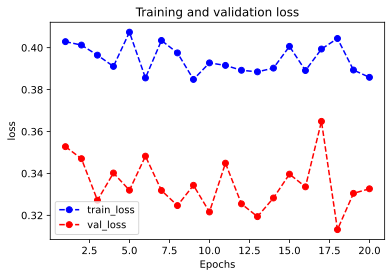

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1,len(train_metrics)+1)
    
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro--')
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])
    plt.show()

plot_metric(dfhistory,"loss")

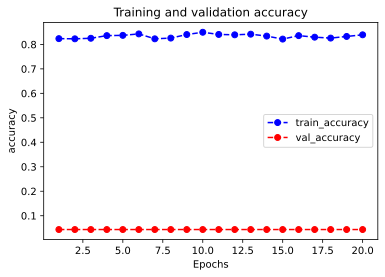

In [38]:
plot_metric(dfhistory, "accuracy")

In [39]:
# 五、使用模型！！！！！！

# 1. 预测概率
y_pred_porbs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_porbs

tensor([[0.0030],
        [0.5680],
        [0.2050],
        [0.8948],
        [0.7468],
        [0.8876],
        [0.0264],
        [0.9399],
        [0.6184],
        [0.1735]])

In [43]:
# 2. 预测类别
y_pred = torch.where(y_pred_porbs>0.5, 
        torch.ones_like(y_pred_porbs), 
        torch.zeros_like(y_pred_porbs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

In [44]:
# 六、 保存模型！！！！！！
# Pytorch 有两种保存模型的方式，都是通过调用pickle序列化方法实现的。
# 第一种方法只保存模型参数。 
# 第二种方法保存完整模型。 推
# 荐使用第一种，第二种方法可能在切换设备和目录的时候出现各种问题。

print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [46]:
# 1. 保存模型参数

torch.save(net.state_dict(), "C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/net_parameter.pkl")

net_clone = create_net()
net_clone.load_state_dict(torch.load("C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/net_parameter.pkl"))

net_clone.forward(torch.tensor(x_test[0:10]).float()).data

tensor([[0.0030],
        [0.5680],
        [0.2050],
        [0.8948],
        [0.7468],
        [0.8876],
        [0.0264],
        [0.9399],
        [0.6184],
        [0.1735]])

In [47]:
# 2.保存完整模型

torch.save(net, "C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/net_model.pkl")
net_loaded = torch.load("C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/net_model.pkl")
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.0030],
        [0.5680],
        [0.2050],
        [0.8948],
        [0.7468],
        [0.8876],
        [0.0264],
        [0.9399],
        [0.6184],
        [0.1735]])